# Hierarchical partial pooling

Original code and explanations can be found here: https://docs.pymc.io/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import theano.tensor as tt

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [9]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")

In [11]:
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

## The model

1. **population player performance:** We will assume that there exists a hidden factor (phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.
2. **variance in population batting averages:** Next, we introduce a hyperparameter kappa to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds.
3. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter, it may also be parametrized in terms of its mean μ∈[0,1] and sample size (a proxy for variance) ν=α+β(ν>0).
4. **hit or miss**: binomial sampling distribution for the data

In [17]:
N = len(hits)

with pm.Model() as baseball_model:
    phi = pm.Uniform("phi", lower=0.0, upper=1.0) # mean for probability of hitting the ball
    
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log)) # variance for probability of hitting the ball
    
    thetas = pm.Beta("thetas", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=N)
                    
    y = pm.Binomial("y", n=at_bats, p=thetas, observed=hits)
    

In [18]:
with baseball_model:
    theta_new = pm.Beta("theta_new", alpha=phi * kappa, beta=(1.0 - phi)*kappa)
    y_new = pm.Binomial("y_new", n=4, p=theta_new, observed=0)

In [19]:
with baseball_model:
    trace = pm.sample(2000, tune=2000, chains=2, target_accept=0.95, return_inferencedata=True)
    
    assert all(pm.rhat(trace) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_new, thetas, kappa_log, phi]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8883912261768036, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

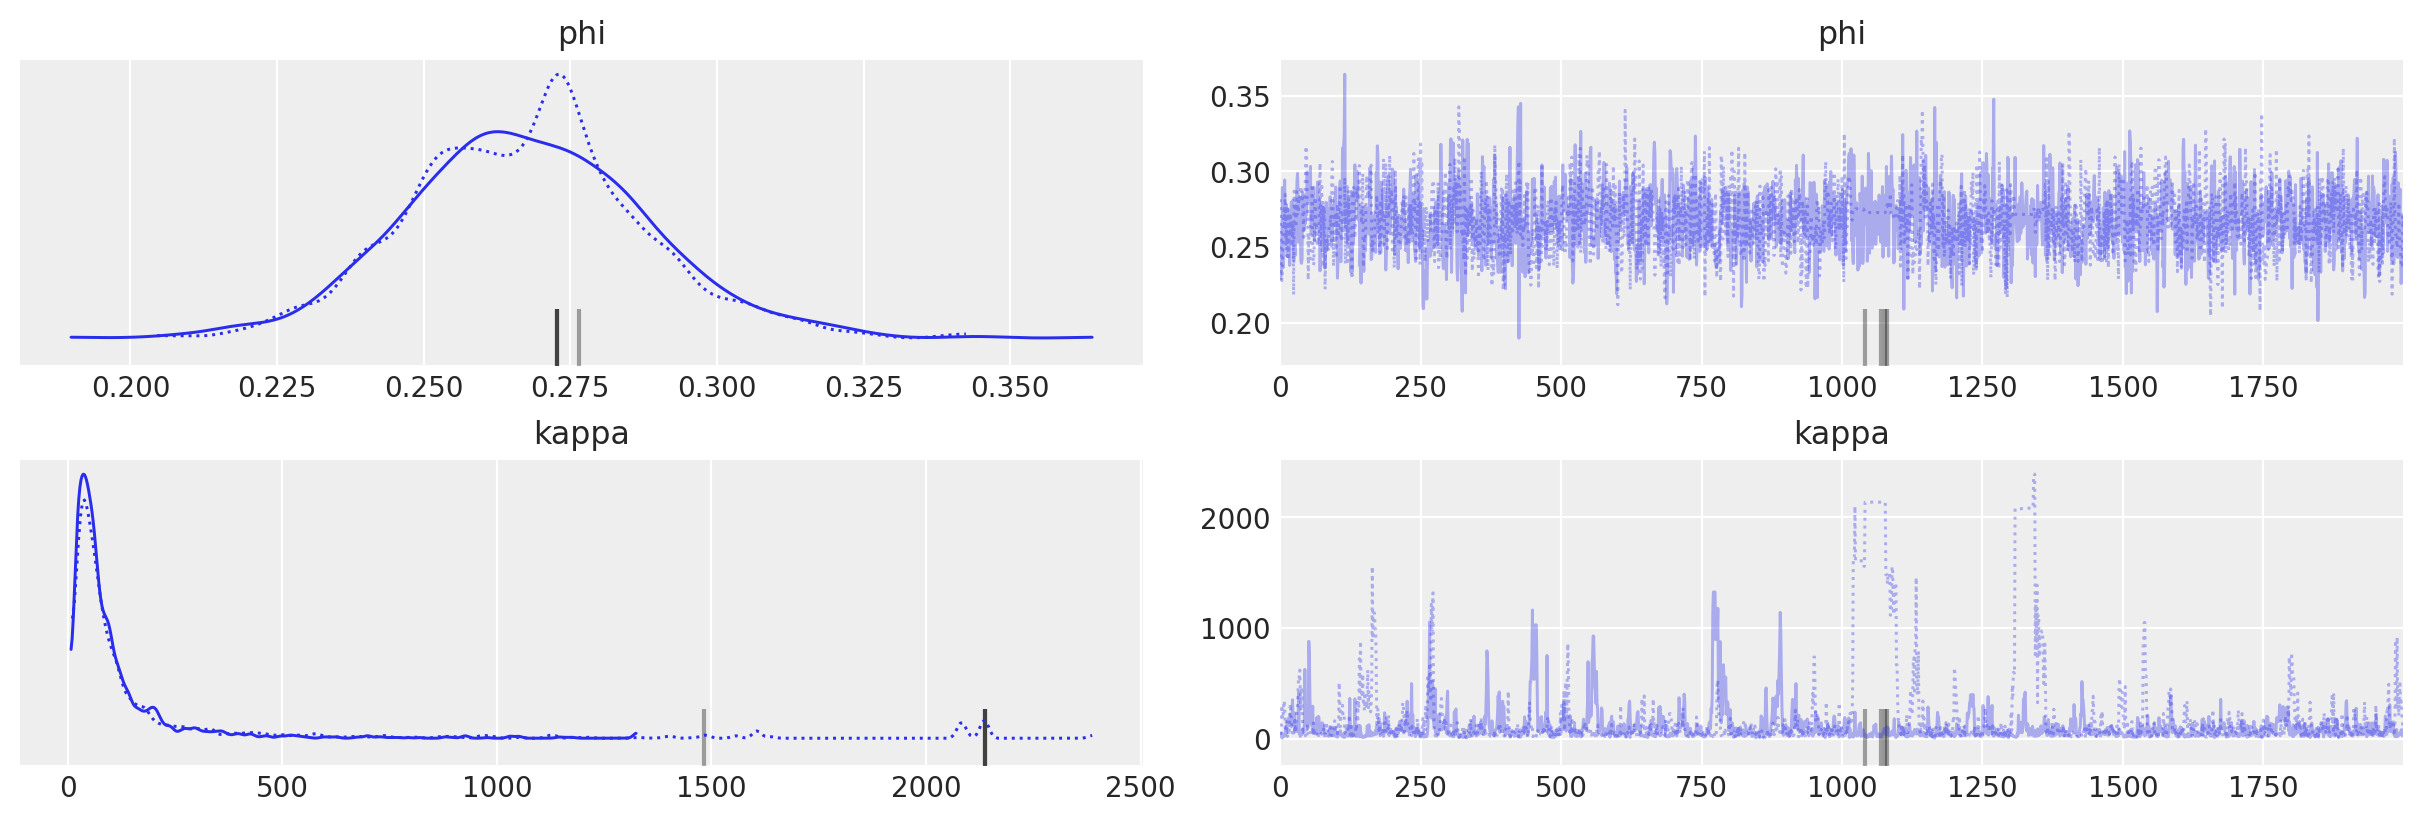

In [21]:
az.plot_trace(trace, var_names=["phi", "kappa"])

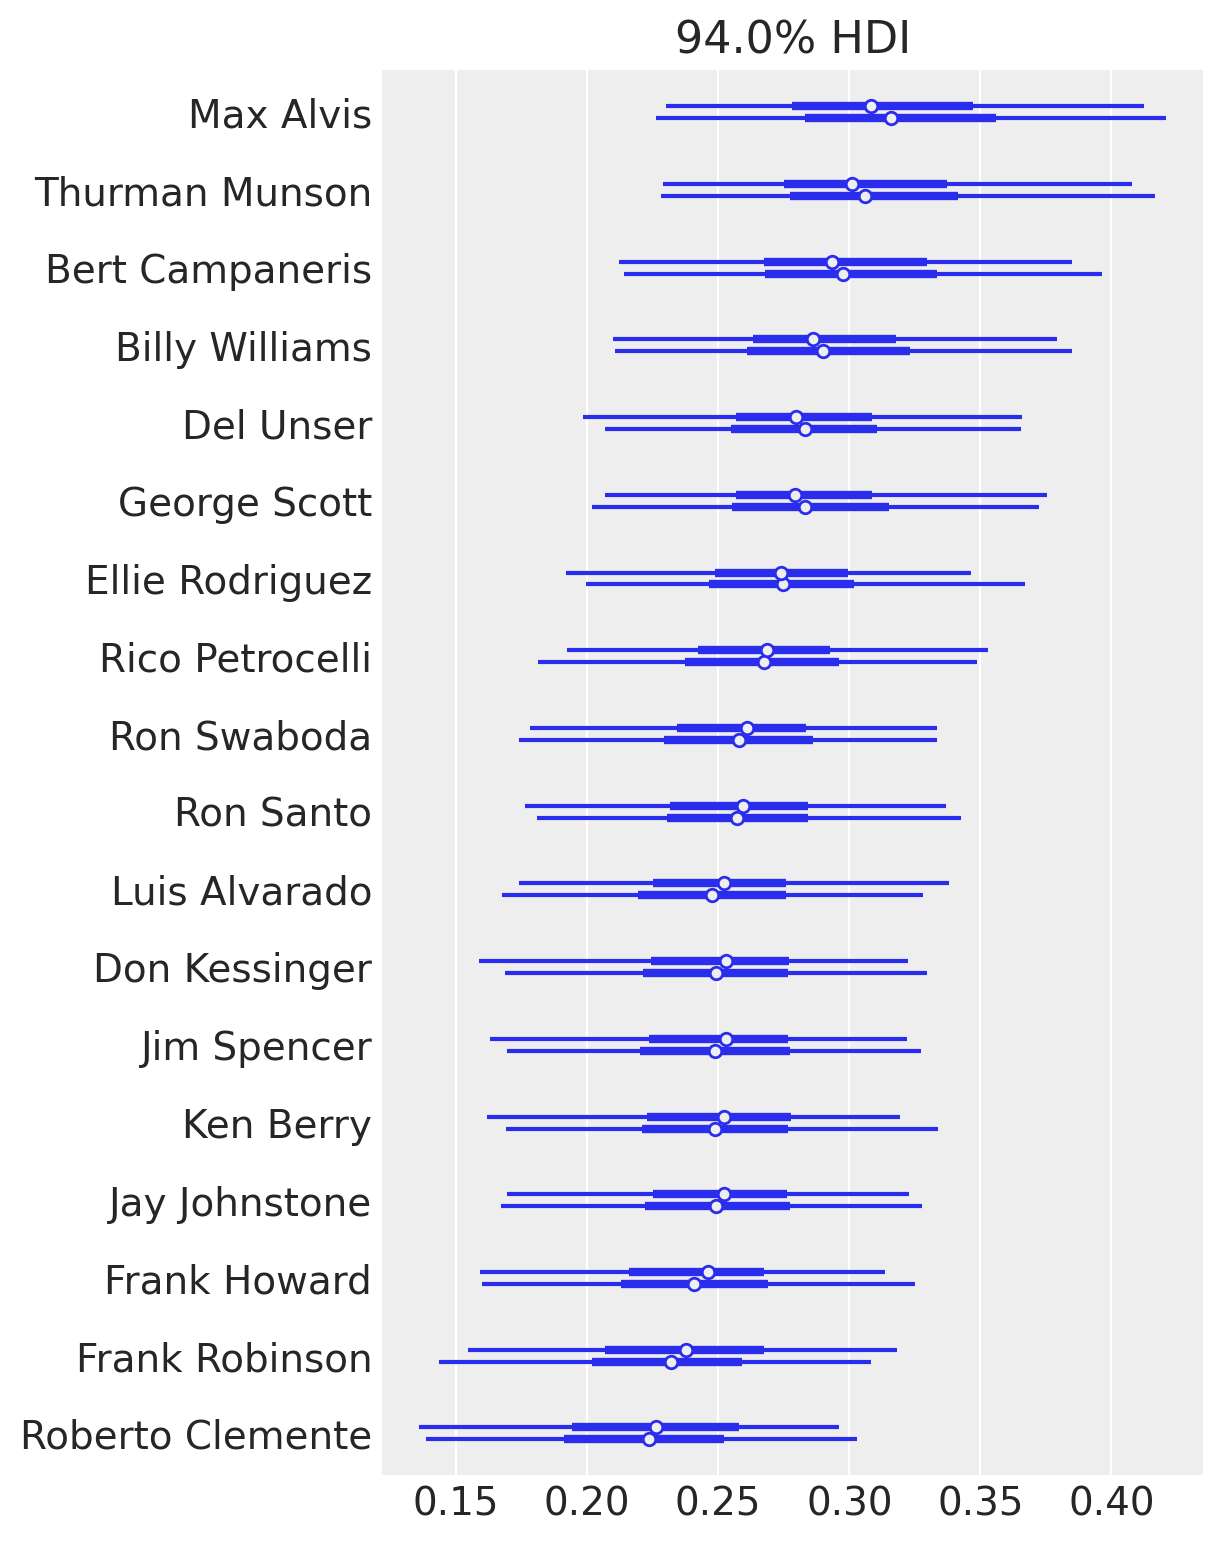

In [25]:
player_names = data.apply(lambda x: x.FirstName + " " + x.LastName, axis=1)
ax = az.plot_forest(trace, var_names=["thetas"])
ax[0].set_yticklabels(player_names.tolist());

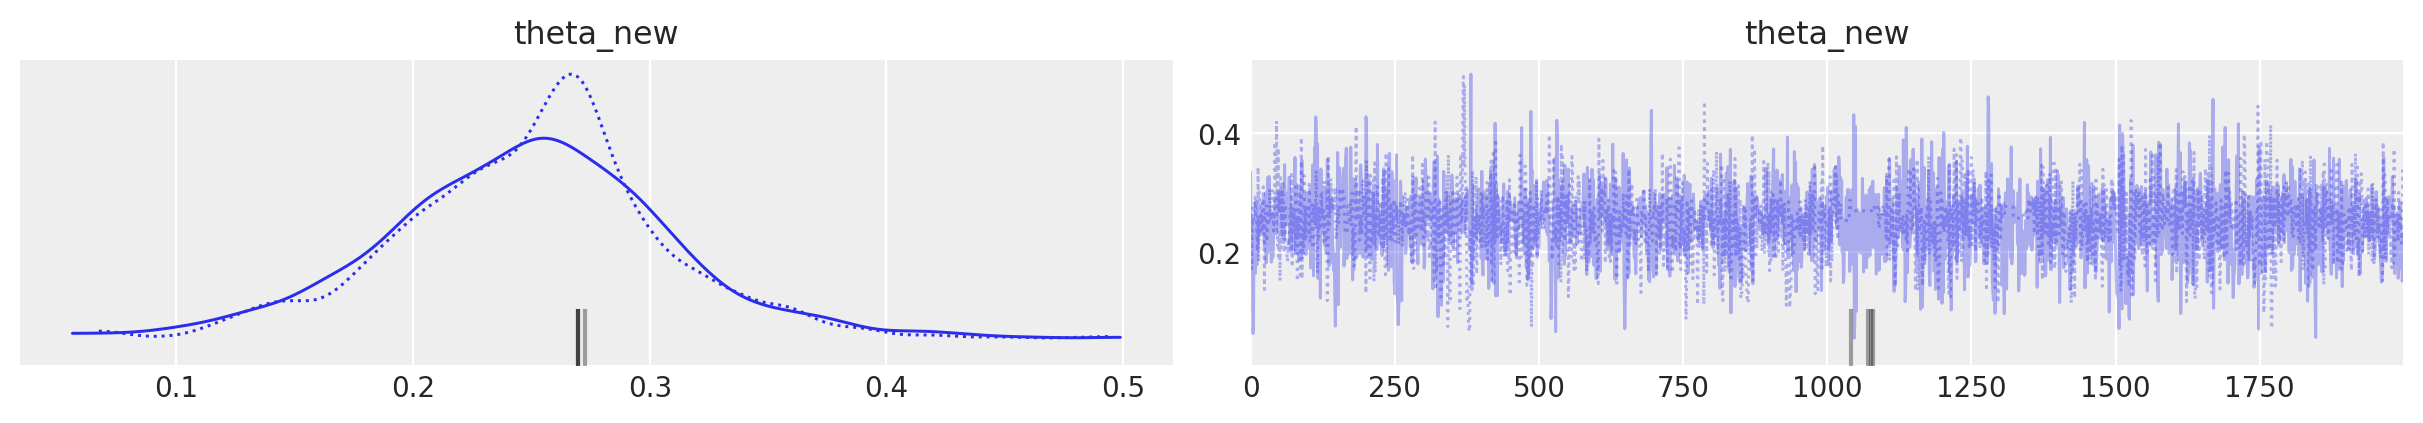

In [26]:
az.plot_trace(trace, var_names=["theta_new"]);